## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording     # (Use this for old data)
from load_recording_data import LoadRecordingData                 # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools

2024-02-05 12:16:20.974834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 12:16:21.848983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-05 12:16:21.849095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-05 12:16:21.849105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
gpu_id = 2
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Load data

In [3]:
intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20) #, random_state=42)

extrasTrain = extrasTrainVal[idx_train]
intrasTrain = intrasTrainVal[idx_train]
extrasVal = extrasTrainVal[idx_val]
intrasVal = intrasTrainVal[idx_val]


# dataset = LoadRecordingData()
# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2
# extrasTest = dataset['8k'].extras_unseen2
# intrasTest = dataset['8k'].intras_unseen2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [4]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

### Smooth the data by applying moving filter

In [5]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)
temp = []

for rec in extrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
extrasTrain = np.array(temp)

# Validation set
temp = []

for rec in intrasVal:
    temp.append(moving_filter(rec, windowSize))
    
intrasVal = np.array(temp)
temp = []

for rec in extrasVal:
    temp.append(moving_filter(rec, windowSize))
    
extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)
temp = []

for rec in extrasTest:
    temp.append(moving_filter(rec, windowSize))
    
extrasTest = np.array(temp)

### Function to extract features

In [65]:
def GetFeatures(intras, extras):
    XBefore = []
    XAfter = []
    Y = []
    indicesBefore = []
    indicesAfter = []
    windowSize = 20
    
    featureNames = ['d2eAP', 'deAP', 'eAP', 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
    s = [i for i in range(len(featureNames))]
    combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
    featureCombs = []
    
    for comb in combs[1:]:
        for tpl in comb:
            name = ""

            for ind in tpl:
                name += "*"+featureNames[ind]

            featureCombs.append(name)
            
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
    
    for i in range(len(extras)):
        iAP = intras[i]
        diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
        d2iAP = np.array(moving_filter(np.gradient(diAP), windowSize))

        eAP = extras[i]
        deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
        d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
        
        breakInd = np.argmax(eAP[:1500])+300
            
#         iAP = intras[i]
#         diAP = np.gradient(iAP)
#         d2iAP = np.gradient(diAP)

#         eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)

        featureList1 = [d2eAP[:breakInd], deAP[:breakInd], eAP[:breakInd], np.exp(d2eAP)[:breakInd], np.exp(deAP)[:breakInd], np.exp(eAP)[:breakInd], t[:breakInd]]
        featureList2 = [d2eAP[breakInd:], deAP[breakInd:], eAP[breakInd:], np.exp(d2eAP)[breakInd:], np.exp(deAP)[breakInd:], np.exp(eAP)[breakInd:], t[breakInd:]]
            
        featureMatrix1 = []
        featureMatrix2 = []
        
        for comb in combs[1:]:
            for tpl in comb:
                feature1 = 1
                feature2 = 1
                
                for ind in tpl:
                    feature1 = feature1*featureList1[ind]
                    feature2 = feature2*featureList2[ind]
                    
                featureMatrix1.append(feature1)
                featureMatrix2.append(feature2)
        
        start = int(len(XBefore))
        XBefore.extend(np.array(featureMatrix1).T)
        end = int(len(XBefore))-1
        indicesBefore.append([start, end])
        
        start = int(len(XAfter))
        XAfter.extend(np.array(featureMatrix2).T)
        end = int(len(XAfter))-1
        indicesAfter.append([start, end])
        
        Y.extend(diAP)
        
    XBefore = np.array(XBefore)
    XAfter = np.array(XAfter)
    Y = np.array(Y)
     
    return XBefore, XAfter, Y, indicesBefore, indicesAfter

### Extract features from training data

In [66]:
XBefore0, XAfter0, Y, indicesBefore, indicesAfter = GetFeatures(intrasTrain, extrasTrain)
scalerBefore = StandardScaler()
scalerAfter = StandardScaler()
# scalerY0 = StandardScaler()

XBefore0 = scalerBefore.fit_transform(XBefore0)
XAfter0 = scalerAfter.fit_transform(XAfter0)
# Y0 = scalerY0.fit_transform(Y0.reshape(-1, 1)).reshape(-1)

### Extract features from validation and test data for hyperparam tuning and evaluation

In [67]:
X_valBefore0, X_valAfter0, Y_val, indicesBefore_val, indicesAfter_val = GetFeatures(intrasVal, extrasVal)
X_valBefore0 = scalerBefore.transform(X_valBefore0)
X_valAfter0 = scalerAfter.transform(X_valAfter0)
# Y_val0 = scalerY0.transform(Y_val0.reshape(-1, 1)).reshape(-1)

In [68]:
X_testBefore0, X_testAfter0, Y_test, indicesBefore_test, indicesAfter_test = GetFeatures(intrasTest, extrasTest)
X_testBefore0 = scalerBefore.transform(X_testBefore0)
X_testAfter0 = scalerAfter.transform(X_testAfter0)

### Estimate parameters of Physics loss equation

In [69]:
# This cell estimates parameters in physics loss equation using training data.
# This equation is then used as a constraint in the loss function of the model.
windowSize = 30

v = intrasTrain
dv = []
d2v = []
d3v = []

for rec in v:
    dv.append(moving_filter(np.gradient(rec), windowSize))

dv = np.array(dv)

for rec in dv:
    d2v.append(moving_filter(np.gradient(rec), windowSize))

d2v = np.array(d2v)

for rec in d2v:
    d3v.append(moving_filter(np.gradient(rec), windowSize))

d3v = np.array(d3v)

v = np.reshape(v, (-1))
dv = np.reshape(dv, (-1))
d2v = np.reshape(d2v, (-1))
d3v = np.reshape(d3v, (-1))

vFeatures = np.array([d2v*(v**2), v**3, dv*(v**2), v**4, v*d2v, v*dv, (d2v)**2, (d2v*dv), (v**3)*d2v, (v**3)*dv, v**5, (dv)**2, 
                      d2v, d3v*v, dv, np.ones(v.shape)]).T

target = np.array([d3v*(v**2)]).T
params = np.linalg.inv(vFeatures.T.dot(vFeatures)).dot(vFeatures.T.dot(target))

### Linear regression model with custom loss

In [70]:
class LinearReg(keras.layers.Layer):
    def __init__(self, numParams, lamda):
        super(LinearReg, self).__init__()
        self.w = self.add_weight(shape=(numParams, 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(1,), initializer="zeros", trainable=True)
        self.lamda = lamda
        
    def call(self, x):
        return tf.matmul(x, self.w) + self.b
    
    def loss_fn(self, output, target):
        reg = self.lamda*(tf.math.reduce_sum(tf.math.abs(self.w)) + tf.math.reduce_sum(tf.math.abs(self.b)))
        sqError = tf.reduce_sum(tf.math.square(output - target))
        
        dv = tf.reshape(output, (-1)).numpy()
#         dv = np.gradient(v)
        v = np.cumsum(dv)
        d2v = np.gradient(dv)
        d3v = np.gradient(d2v)
        
        vFeatures = np.array([d2v*(v**2), v**3, dv*(v**2), v**4, v*d2v, v*dv, (d2v)**2, (d2v*dv), (v**3)*d2v, (v**3)*dv, v**5, (dv)**2, 
                      d2v, d3v*v, dv, np.ones(v.shape)]).T
        target = np.array([d3v*(v**2)]).T
        
        phyErr = tf.reduce_sum(tf.math.square(vFeatures.dot(params) - target))
#         d1mse = tf.reduce_mean(tf.math.square(tf.math.cumsum(output, 0) - tf.math.cumsum(target, 0)))
#         mse = tf.reduce_mean(tf.math.square(tf.math.cumsum(tf.math.cumsum(output, 0), 0) - tf.math.cumsum(tf.math.cumsum(target, 0), 0)))

        return reg + sqError + tf.cast(phyErr, tf.float32)# + d1mse + mse

### Training

In [79]:
keras.utils.set_random_seed(812)

XBefore = XBefore0#[:, mask]
XAfter = XAfter0#[:, mask2]
X_valBefore = X_valBefore0#[:, mask]
X_valAfter = X_valAfter0#[:, mask2]
X_testBefore = X_testBefore0#[:, mask]
X_testAfter = X_testAfter0#[:, mask2]


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=10000, decay_rate=0.95)

epochs = 50
batch_size = len(extrasTrain[0])

reg_selected = LinearReg(XBefore.shape[1], 1)
reg_selected2 = LinearReg(XAfter.shape[1], 1)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

for epoch in range(epochs):
    totalLoss = 0.0

    for i in range(len(indicesBefore)):
        loss = 0.0
        
        with tf.GradientTape() as tape:
            output1 = reg_selected(tf.convert_to_tensor(XBefore[indicesBefore[i][0]:indicesBefore[i][1]+1], dtype='float32'))
            output1 = tf.reshape(output1, (-1))
            output2 = reg_selected2(tf.convert_to_tensor(XAfter[indicesAfter[i][0]:indicesAfter[i][1]+1], dtype='float32'))
            output2 = tf.reshape(output2, (-1))

            loss = reg_selected.loss_fn(tf.concat([output1, output2], 0), tf.convert_to_tensor(Y[8000*i:8000*(i+1)], dtype='float32'))
            loss += reg_selected2.loss_fn(tf.concat([output1, output2], 0), tf.convert_to_tensor(Y[8000*i:8000*(i+1)], dtype='float32'))
            totalLoss += loss
            
        variables = reg_selected.trainable_weights
        variables.extend(reg_selected2.trainable_weights)
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        
    if(epoch%5==0):
        print("Epoch ", epoch, " complete with loss ", totalLoss/len(indicesBefore))

# output = []
# for i in range(len(indicesBefore)):
#     output1 = reg_selected(tf.convert_to_tensor(XBefore[indicesBefore[i][0]:indicesBefore[i][1]+1], dtype='float32'))
#     output1 = tf.reshape(output1, (-1))
#     output2 = reg_selected2(tf.convert_to_tensor(XAfter[indicesAfter[i][0]:indicesAfter[i][1]+1], dtype='float32'))
#     output2 = tf.reshape(output2, (-1))
#     output.extend(tf.concat([output1, output2], 0).numpy())
    
# output = np.array(output)
    
# print("MSE on train with model", mse(output, Y))
# print("MAE on train with model", mae(output, Y))

Epoch  0  complete with loss  tf.Tensor(5.9848573e+19, shape=(), dtype=float32)
Epoch  5  complete with loss  tf.Tensor(72772840000.0, shape=(), dtype=float32)
Epoch  10  complete with loss  tf.Tensor(14707845.0, shape=(), dtype=float32)
Epoch  15  complete with loss  tf.Tensor(233456.83, shape=(), dtype=float32)
Epoch  20  complete with loss  tf.Tensor(2015.5735, shape=(), dtype=float32)
Epoch  25  complete with loss  tf.Tensor(91.32989, shape=(), dtype=float32)
Epoch  30  complete with loss  tf.Tensor(25.152365, shape=(), dtype=float32)
Epoch  35  complete with loss  tf.Tensor(14.284269, shape=(), dtype=float32)
Epoch  40  complete with loss  tf.Tensor(10.970222, shape=(), dtype=float32)
Epoch  45  complete with loss  tf.Tensor(9.183032, shape=(), dtype=float32)


### Evaluate model on validation data

In [80]:
valOut = []
for i in range(len(indicesBefore_val)):
    valOut1 = reg_selected(tf.convert_to_tensor(X_valBefore[indicesBefore_val[i][0]:indicesBefore_val[i][1]+1], dtype='float32'))
    valOut1 = tf.reshape(valOut1, (-1))
    valOut2 = reg_selected2(tf.convert_to_tensor(X_valAfter[indicesAfter_val[i][0]:indicesAfter_val[i][1]+1], dtype='float32'))
    valOut2 = tf.reshape(valOut2, (-1))
    valOut.extend(tf.concat([valOut1, valOut2], 0).numpy())
    
valOut = np.array(valOut)

# predd2_selected = tf.reshape(valOut, (-1, 8000)).numpy()

predd1_selected = tf.reshape(valOut, (-1, 8000)).numpy()
# predd1_selected = np.cumsum(predd2_selected, axis=1)

# prediAP_selected = tf.reshape(valOut, (-1, 8000)).numpy()
prediAP_selected = np.cumsum(predd1_selected, axis=1)

# yd2 = np.array(Y_test).reshape((-1, 8000))
# yd1 = np.cumsum(yd2, axis=1)
yiAP = intrasVal

print("MSE on val d0 with reg_selected", mse(prediAP_selected, yiAP))
print("MAE on val d0 with reg_selected", mae(prediAP_selected, yiAP))
print("DTW on val d0 with reg_selected", dtw(prediAP_selected, yiAP))

MSE on val d0 with reg_selected 6.625203210038991
MAE on val d0 with reg_selected 1.9002800040500545
DTW on val d0 with reg_selected 14120.347792758115


### Evaluate model on test data

In [64]:
testOut = []
for i in range(len(indicesBefore_test)):
    testOut1 = reg_selected(tf.convert_to_tensor(X_testBefore[indicesBefore_test[i][0]:indicesBefore_test[i][1]+1], dtype='float32'))
    testOut1 = tf.reshape(testOut1, (-1))
    testOut2 = reg_selected2(tf.convert_to_tensor(X_testAfter[indicesAfter_test[i][0]:indicesAfter_test[i][1]+1], dtype='float32'))
    testOut2 = tf.reshape(testOut2, (-1))
    testOut.extend(tf.concat([testOut1, testOut2], 0).numpy())
    
testOut = np.array(testOut)

# predd2_selected = tf.reshape(testOut, (-1, 8000)).numpy()

predd1_selected = tf.reshape(testOut, (-1, 8000)).numpy()
# predd1_selected = np.cumsum(predd2_selected, axis=1)

# prediAP_selected = tf.reshape(testOut, (-1, 8000)).numpy()
prediAP_selected = np.cumsum(predd1_selected, axis=1)

yiAP = intrasTest

print("MSE on test d0 with reg_selected", mse(prediAP_selected, yiAP))
print("MAE on test d0 with regselected", mae(prediAP_selected, yiAP))
print("DTW on test d0 with reg_selected", dtw(prediAP_selected, yiAP))

MSE on test d0 with reg_selected 0.009774856874998652
MAE on test d0 with regselected 0.07407770380104531
DTW on test d0 with reg_selected 90.2729640513853


### Select features with high coefficient magnitude

In [39]:
featureWeights = np.absolute(np.reshape(reg_selected.w.numpy(), (-1)))
featureWeights2 = np.absolute(np.reshape(reg_selected2.w.numpy(), (-1)))

In [44]:
mask = featureWeights >= np.sort(featureWeights)[-5]
mask2 = featureWeights2 >= np.sort(featureWeights2)[-5]

In [45]:
featureNames = ['d2eAP', 'deAP', 'eAP', 'np.exp(d2eAP)', 'np.exp(deAP)', 'np.exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
s = [i for i in range(len(featureNames))]
combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
featureCombs = []

for comb in combs[1:]:
    for tpl in comb:
        name = ""

        for ind in tpl:
            name += "*"+featureNames[ind]

        featureCombs.append(name)

#### Only for weight params
# featureCombs.extend(["max"+str(i) for i in range(-50, 50)])
# featureCombs.extend(["min"+str(i) for i in range(100)])
####

print(np.array(featureCombs)[mask])
print(np.array(featureCombs)[mask2])

['*deAP' '*t' '*np.exp(deAP)*t' '*np.exp(eAP)*t'
 '*eAP*np.exp(deAP)*np.exp(eAP)*t']
['*t' '*np.exp(d2eAP)*t' '*eAP*np.exp(deAP)*np.exp(eAP)'
 '*d2eAP*deAP*eAP*np.exp(eAP)*t'
 '*d2eAP*deAP*eAP*np.exp(d2eAP)*np.exp(deAP)*t']


In [23]:
print(reg_selected.w.numpy())
print(reg_selected.b.numpy())
print(reg_selected2.w.numpy())
print(reg_selected2.b.numpy())

[[-0.00367152]
 [ 0.00439196]
 [ 0.03878922]
 [-0.03856178]]
[0.00089367]
[[-1.2247594e-02]
 [ 1.2227931e-02]
 [ 1.6773080e-06]
 [-2.8413642e-06]]
[-0.00013851]


In [42]:
# 219, 133, 48
import pickle
diAP_physics_piecewise = {}

### Choose a recording at random from the test set

In [69]:
ind = random.randint(0, len(extrasTest))#219, 133, 48
print(ind)

xBefore = X_testBefore[indicesBefore_test[ind][0]:indicesBefore_test[ind][1]]
xAfter = X_testAfter[indicesAfter_test[ind][0]:indicesAfter_test[ind][1]]
y = Y_test[ind*8000:(ind+1)*8000]

48


### Get model prediction for the chosen recording

In [70]:
out1 = reg_selected(tf.convert_to_tensor(xBefore, dtype='float32'))
out1 = tf.reshape(out1, (-1)).numpy()
out2 = reg_selected2(tf.convert_to_tensor(xAfter, dtype='float32'))
out2 = tf.reshape(out2, (-1)).numpy()
pred = np.concatenate((out1, out2))
# pred = reg_selected.predict(x)
# pred1 = reg1.predict(x1)

### Prediction plots

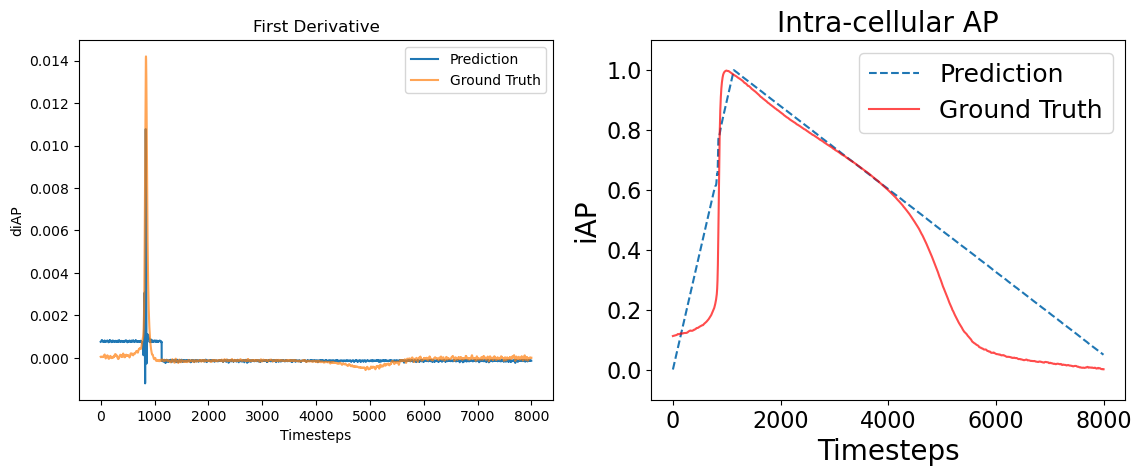

In [71]:
transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig0.tight_layout(pad=4)

# Plot second derivative
ax0[0].plot(pred)
ax0[0].plot(y, alpha=transparency)
ax0[0].legend(['Prediction', 'Ground Truth'])
ax0[0].title.set_text("First Derivative")
ax0[0].set_xlabel("Timesteps")
ax0[0].set_ylabel("diAP")

# Plot first derivative
ax0[1].plot(np.cumsum(pred), linestyle='dashed')
# ax0[1].plot(moving_filter(np.gradient(intrasTest[ind]), windowSize), alpha=transparency)
ax0[1].plot(intrasTest[ind], alpha=transparency, color='red')
ax0[1].legend(['Prediction', 'Ground Truth'], prop={'size': 18})
ax0[1].title.set_text("Intra-cellular AP")
ax0[1].title.set_fontsize(20)
ax0[1].set_xlabel("Timesteps", fontsize=20)
ax0[1].set_ylabel("iAP", fontsize=20)
ax0[1].set_ylim([-0.1, 1.1])
ax0[1].tick_params(axis='x', labelsize=16)
ax0[1].tick_params(axis='y', labelsize=16)

# Plot iAP
# ax0[2].plot(np.cumsum(np.cumsum(pred)))
# ax0[2].plot(intrasVal[ind], alpha=transparency)
# ax0[2].legend(['Prediction', 'Ground Truth'])
# ax0[2].title.set_text("Intra-cellular AP")
# ax0[2].set_xlabel("Timesteps")
# ax0[2].set_ylabel("iAP")

In [72]:
diAP_physics_piecewise[48] = [np.cumsum(pred), intrasTest[ind]]

In [73]:
diAP_physics_piecewise

{219: [array([ 0.00076196,  0.0015244 ,  0.00228808, ..., -0.08537691,
         -0.08551218, -0.08564871], dtype=float32),
  array([0.12118891, 0.12104303, 0.12089716, ..., 0.00630926, 0.00623632,
         0.00623632])],
 183: [array([ 0.00081025,  0.00161489,  0.00240895, ..., -0.06023562,
         -0.06037301, -0.06050666], dtype=float32),
  array([0.13086717, 0.13134893, 0.13165864, ..., 0.00554026, 0.00529938,
         0.00516173])],
 145: [array([ 0.0008199 ,  0.0016491 ,  0.00248538, ..., -0.00674303,
         -0.00688065, -0.00701436], dtype=float32),
  array([0.12026866, 0.12029851, 0.12050746, ..., 0.0061791 , 0.00614925,
         0.00620896])],
 133: [array([ 0.00080164,  0.00161622,  0.00244135, ..., -0.00612019,
         -0.00625526, -0.00639137], dtype=float32),
  array([0.1232358 , 0.12332186, 0.12337923, ..., 0.00461847, 0.00461847,
         0.00467585])],
 48: [array([0.00075371, 0.00150675, 0.00226216, ..., 0.05038154, 0.05024592,
         0.05011095], dtype=float32),


In [74]:
with open('diAP_physics_piecewise.pkl', 'wb') as fl:
    pickle.dump(diAP_physics_piecewise, fl)